In [ ]:
import csv
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import re2 as re
except:
    import re

from tqdm import tqdm
from urllib.parse import urlparse
from category_encoders import TargetEncoder
from itertools import product
from pprint import pprint
from numpy import array
from scipy.stats import pearsonr, spearmanr, pointbiserialr

from sklearn.model_selection import (
    cross_val_score,
    validation_curve,
    GridSearchCV,
    train_test_split,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    make_scorer,
    mean_squared_error,
)
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

In [ ]:
# all_df_883 = pd.read_csv("all_df_883.csv", index_col=0)
# # JAVASCRIPT NEW CREATED FEATURES
# new_features = all_df_883[all_df_883.columns[303:]].copy()
# new_features.drop(["contentname", "label"], axis=1, inplace=True)
# new_features.fillna(0, inplace=True)

# ngram_train, ngram_test = train_test_split(new_features, test_size=0.2, random_state=42)
# ngram_train.reset_index(drop=True, inplace=True)
# ngram_test.reset_index(drop=True, inplace=True)

# integ_train, integ_test = train_test_split(integ_df, test_size=0.2, random_state=42)
# integ_train.reset_index(drop=True, inplace=True)
# integ_test.reset_index(drop=True, inplace=True)

# train_df = pd.concat(
#     [
#         integ_train[integ_train.columns[:-1]],
#         train_url230_sg,
#         ngram_train,
#         integ_train["label"],
#     ],
#     axis=1,
# )
# test_df = pd.concat(
#     [
#         integ_test[integ_test.columns[:-1]],
#         test_url230_sg,
#         ngram_test,
#         integ_test["label"],
#     ],
#     axis=1,
# )

In [ ]:
# avg_indent = train_df['avg_ident'] ** -1
# for i in range(len(avg_indent)):
#     if avg_indent[i] == np.inf:
#         avg_indent[i] = 0
# train_df['avg_ident'] = avg_indent

# avg_indent = test_df['avg_ident'] ** -1
# for i in range(len(avg_indent)):
#     if avg_indent[i] == np.inf:
#         avg_indent[i] = 0
# test_df['avg_ident'] = avg_indent

# train_df.to_csv('all_df_883_train.csv')
# test_df.to_csv('all_df_883_test.csv')

In [ ]:
train_df = pd.read_csv("all_df_883_train.csv", index_col=0)
test_df = pd.read_csv("all_df_883_test.csv", index_col=0)

In [ ]:
cnt = 0
filtered_feat = []
for i in train_df.columns[2:-1]:
    correlation, p_value = pointbiserialr(train_df.label, train_df[i])
    if p_value > 0.1:
        print(i)
        print("Correlation coefficient:", correlation)
        print("p-value:", p_value)
        cnt += 1
        filtered_feat.append(i)
train_df.drop(filtered_feat, inplace=True, axis=1)
print("Removed : ", cnt)

In [ ]:
X = train_df.drop(["visit_id", "name", "label"], axis=1)
y = train_df.label

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, shuffle=True, test_size=0.2, random_state=42
)  # train / vaild
# Train a RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame(
    {"feature": X_train.columns.to_list(), "importance": importances}
)
print("feature_importances")
# Get permutation importances
result = permutation_importance(
    clf, X_valid, y_valid, n_repeats=5, random_state=42, n_jobs=-1
)
print("result")
# Convert the importances into a DataFrame
perm_importances = pd.DataFrame(
    {"feature": X_train.columns.to_list(), "importance": result.importances_mean}
)

# Print permutation importances
print(perm_importances)

feature_importances.columns = ["feature", "RFI_importance"]
perm_importances.columns = ["feature", "PI_importance"]
concat = feature_importances.copy()
concat = pd.concat([concat, perm_importances.PI_importance], axis=1)
concat["RFI_PI_MEAN"] = (concat.RFI_importance + concat.PI_importance) / 2
concat
# concat.to_csv("RFI_PI_js.csv")

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, shuffle=True, test_size=0.2, random_state=42
)  # train / vaild
# Train a RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame(
    {"feature": X_train.columns.to_list(), "importance": importances}
)
print("feature_importances")
# Get permutation importances
result = permutation_importance(
    clf, X_valid, y_valid, n_repeats=5, random_state=42, n_jobs=-1
)
print("result")
# Convert the importances into a DataFrame
perm_importances = pd.DataFrame(
    {"feature": X_train.columns.to_list(), "importance": result.importances_mean}
)

# Print permutation importances
print(perm_importances)

feature_importances.columns = ["feature", "RFI_importance"]
perm_importances.columns = ["feature", "PI_importance"]
concat = feature_importances.copy()
concat = pd.concat([concat, perm_importances.PI_importance], axis=1)
concat["RFI_PI_MEAN"] = (concat.RFI_importance + concat.PI_importance) / 2
concat
concat.to_csv("RFI_PI_1006.csv")

In [ ]:
graphFeatures = [  # 52
    "num_nodes",
    "num_edges",
    "nodes_div_by_edges",
    "edges_div_by_nodes",
    "in_degree",
    "out_degree",
    "in_out_degree",
    "average_degree_connectivity",
    "is_ancestor_script",
    "ascendant_has_ad_keyword",
    "descendant_of_eval_or_function",
    "ascendant_script_has_eval_or_function",
    "ascendant_script_has_fp_keyword",
    "ascendant_script_length",
    "ancestors",
    "descendants",
    "closeness_centrality",
    "eccentricity",
    "num_script_predecessors",
    "num_script_successors",
    "num_requests_received",
    "num_redirects_sent",
    "num_redirects_rec",
    "max_depth_redirect",
    "indirect_in_degree",
    "indirect_out_degree",
    "indirect_ancestors",
    "indirect_descendants",
    "indirect_closeness_centrality",
    "indirect_average_degree_connectivity",
    "indirect_eccentricity",
    "indirect_mean_in_weights",
    "indirect_min_in_weights",
    "indirect_max_in_weights",
    "indirect_mean_out_weights",
    "indirect_min_out_weights",
    "indirect_max_out_weights",
    "num_set_get_src",
    "num_set_mod_src",
    "num_set_url_src",
    "num_get_url_src",
    "num_set_get_dst",
    "num_set_mod_dst",
    "num_set_url_dst",
    "num_get_url_dst",
    "indirect_all_in_degree",
    "indirect_all_out_degree",
    "indirect_all_ancestors",
    "indirect_all_descendants",
    "indirect_all_closeness_centrality",
    "indirect_all_average_degree_connectivity",
    "indirect_all_eccentricity",
]

pi_is_zero = perm_importances.loc[
    (perm_importances.PI_importance <= 0)
].feature.tolist()
X_wo_graph = X.drop(graphFeatures + pi_is_zero, axis=1)

X_wo_graph = X_wo_graph[X_wo_graph.columns[:260]]
X_train, X_valid, y_train, y_valid = train_test_split(
    X_wo_graph, y, shuffle=True, test_size=0.2, random_state=42
)  # train / vaild

In [ ]:
min_features_to_select = 10
step = 1
selector = RFECV(
    clf,
    step=step,
    cv=5,
    min_features_to_select=min_features_to_select,
    scoring="accuracy",
    n_jobs=-1,
)
print("RFECV")

selector = selector.fit(X_wo_graph, y)
print("selector")

rfecv_support = selector.support_
rfecv_ranking = selector.ranking_
print("RFECV support:", rfecv_support)
print("RFECV ranking:", rfecv_ranking)
selected_perm_importance = perm_importances[rfecv_support]
print(
    "Permutation importance for the selected features by RFECV:",
    selected_perm_importance,
)

mask = selector.get_support()
features = np.array(X_wo_graph.columns.to_list())
best_features = features[mask]

print("All features: ", X_wo_graph.columns.to_list())
print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

<Axes: >

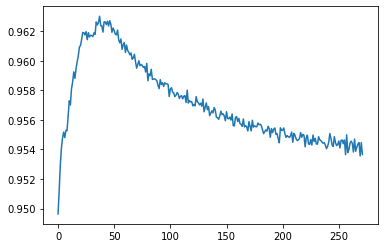

In [1]:
# AdGraph, WebGraph, WTAGraph features (Existing Features)
# Selected best:  47
selected_features = ['content_policy_type','url_length','is_subdomain','is_third_party'
 'keyword_char_present','num_get_storage','num_set_storage'
 'num_get_cookie','num_requests_sent','req_url_15','req_url_18'
 'req_url_21','req_url_22','req_url_33','req_url_38','req_url_44'
 'req_url_91','req_url_110','req_url_121','req_url_135','req_url_176'
 'req_url_179','fqdn_0','fqdn_1','fqdn_3','fqdn_4','fqdn_5','fqdn_6'
 'fqdn_7','fqdn_8','fqdn_9','fqdn_11','fqdn_12','fqdn_13','fqdn_14'
 'fqdn_15','fqdn_16','fqdn_17','fqdn_18','fqdn_19','fqdn_22','fqdn_23'
 'fqdn_24','fqdn_25','fqdn_26','fqdn_27','fqdn_28']

accuracy_score = [0.9496375, 0.9512   , 0.9529375, 0.9540875, 0.954775 , 0.955175 ,
       0.9548   , 0.9552875, 0.9552625, 0.956275 , 0.9572875, 0.9570125,
       0.9581125, 0.9585625, 0.95925  , 0.9588125, 0.9594375, 0.959925 ,
       0.9603125, 0.960925 , 0.9610375, 0.9614375, 0.9619125, 0.9619   ,
       0.96175  , 0.961975 , 0.961425 , 0.9619   , 0.9616125, 0.961725 ,
       0.9617   , 0.9616375, 0.9618875, 0.9617875, 0.962625 , 0.962425 ,
       0.9625875, 0.9630125, 0.962375 , 0.9623625, 0.9619375, 0.9626375,
       0.962625 , 0.96245  , 0.962675 , 0.96235  , 0.9627125, 0.962475 ,
       0.961925 , 0.9622125, 0.9620375, 0.9618   , 0.96175  , 0.962075 ,
       0.9614125, 0.9612125, 0.961475 , 0.960775 , 0.961075 , 0.961225 ,
       0.9605625, 0.9610625, 0.9606875, 0.960575 , 0.9604   , 0.960525 ,
       0.9601   , 0.9602   , 0.9604375, 0.959925 , 0.9595   , 0.9597625,
       0.96     , 0.9596625, 0.95975  , 0.959675 , 0.95955  , 0.9596125,
       0.9592375, 0.959825 , 0.95865  , 0.9591125, 0.9589875, 0.959425 ,
       0.9587375, 0.9587625, 0.958775 , 0.958725 , 0.95865  , 0.958325 ,
       0.9581125, 0.958725 , 0.9584   , 0.9585125, 0.9582625, 0.9585125,
       0.9584375, 0.9584375, 0.9584   , 0.957575 , 0.9580875, 0.958175 ,
       0.957875 , 0.957825 , 0.957575 , 0.9576625, 0.95785  , 0.95775  ,
       0.95745  , 0.9576   , 0.9576375, 0.957425 , 0.9576   , 0.9576375,
       0.957175 , 0.9580125, 0.9571375, 0.9573125, 0.9572125, 0.9572375,
       0.95695  , 0.95705  , 0.95695  , 0.957575 , 0.957225 , 0.95715  ,
       0.9570125, 0.957125 , 0.956925 , 0.9574125, 0.95655  , 0.95685  ,
       0.95715  , 0.9566875, 0.9569   , 0.9562875, 0.95645  , 0.9566125,
       0.956475 , 0.9568375, 0.9566625, 0.956175 , 0.95615  , 0.9560375,
       0.9562625, 0.9565875, 0.95635  , 0.9564125, 0.9562625, 0.9559375,
       0.95655  , 0.9561   , 0.956075 , 0.9561875, 0.9559875, 0.9564   ,
       0.9556   , 0.9556   , 0.9561625, 0.956225 , 0.9558875, 0.9561   ,
       0.95575  , 0.9557   , 0.9555625, 0.9560625, 0.955525 , 0.9556125,
       0.955525 , 0.95525  , 0.9558875, 0.95555  , 0.95525  , 0.955975 ,
       0.9555125, 0.9556   , 0.9555375, 0.9555375, 0.9557875, 0.955675 ,
       0.9557   , 0.9556125, 0.95535  , 0.955075 , 0.9552   , 0.955325 ,
       0.9552375, 0.9555625, 0.9554125, 0.954825 , 0.9554125, 0.9551375,
       0.955375 , 0.95545  , 0.955025 , 0.955075 , 0.9547375, 0.95445  ,
       0.9554625, 0.9552875, 0.9553   , 0.95545  , 0.9550625, 0.9548125,
       0.9549375, 0.9548625, 0.9548125, 0.954925 , 0.955175 , 0.9544875,
       0.9550875, 0.95495  , 0.9547125, 0.9546   , 0.95465  , 0.9547375,
       0.9551375, 0.954825 , 0.955025 , 0.95495  , 0.954175 , 0.9547875,
       0.9549625, 0.954375 , 0.9543375, 0.9546625, 0.9543   , 0.954975 ,
       0.9545375, 0.95475  , 0.9543625, 0.9543625, 0.9548625, 0.95465  ,
       0.9546   , 0.9545   , 0.954425 , 0.9544625, 0.9542875, 0.95405  ,
       0.9542125, 0.9544875, 0.955075 , 0.95475  , 0.9543125, 0.9542   ,
       0.9548625, 0.9544625, 0.9542625, 0.954325 , 0.954575 , 0.9541   ,
       0.9546125, 0.9546375, 0.9543875, 0.9546375, 0.95365  , 0.9549875,
       0.9537875, 0.9539875, 0.9544375, 0.9545625, 0.9544125, 0.953825 ,
       0.9547   , 0.953875 , 0.95415  , 0.9543625, 0.9544625, 0.9535625,
       0.9544625, 0.9536625]

import seaborn as sns

sns.lineplot(accuracy_score)

<Axes: >

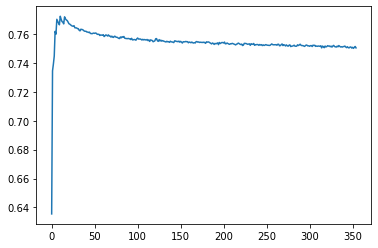

In [3]:
# New Javascript Features
# Selected best:  11
selected_features = ['ng_0_0_2' 'ng_0_15_15' 'ng_2_13_2' 'ng_9_0_0' 'ng_15_0_3' 'ng_15_0_15'
 'ng_15_15_15' 'ast_breadth' 'avg_ident' 'avg_charperline' 'brackettodot']

accuracy_score = [0.63550916, 0.73453788, 0.73925621, 0.74475624, 0.76186954,
       0.75990357, 0.77021555, 0.76881129, 0.76752873, 0.76642404,
       0.77233599, 0.770253  , 0.76866618, 0.76817937, 0.76705596,
       0.7719428 , 0.77053854, 0.76980832, 0.769373  , 0.76841342,
       0.76719639, 0.76688277, 0.76634447, 0.76588574, 0.76552531,
       0.76546446, 0.76579212, 0.76434573, 0.76428488, 0.76425679,
       0.7637653 , 0.76374658, 0.7626138 , 0.76222061, 0.76336274,
       0.76316615, 0.76307253, 0.76255295, 0.76204742, 0.7619304 ,
       0.76191635, 0.76140614, 0.76139677, 0.76108784, 0.76132656,
       0.76044188, 0.76036698, 0.76024528, 0.76054017, 0.7606806 ,
       0.760484  , 0.76073677, 0.76048868, 0.75980996, 0.75986145,
       0.75983336, 0.75901421, 0.75933251, 0.75925761, 0.75922017,
       0.75957123, 0.75828399, 0.75876612, 0.75942144, 0.75915463,
       0.75865846, 0.75942612, 0.75856484, 0.75862101, 0.75789548,
       0.75856484, 0.75782994, 0.75770356, 0.75848527, 0.75834016,
       0.75775973, 0.75782994, 0.75744143, 0.75703887, 0.75690313,
       0.75799377, 0.75740866, 0.75819037, 0.75777845, 0.75832144,
       0.75712781, 0.75697802, 0.75691717, 0.75681419, 0.75697802,
       0.75680483, 0.75660823, 0.75621036, 0.75705292, 0.75596227,
       0.75604653, 0.75623376, 0.75611206, 0.75575631, 0.75668313,
       0.75726824, 0.7565427 , 0.75653334, 0.75657547, 0.75632738,
       0.75589674, 0.75636015, 0.75593887, 0.75621504, 0.75603717,
       0.75585461, 0.75625717, 0.75547078, 0.75598568, 0.75488567,
       0.75597631, 0.75575163, 0.75551291, 0.75469375, 0.75496056,
       0.75531163, 0.75678143, 0.75684696, 0.75538652, 0.7549512 ,
       0.75616355, 0.75518525, 0.7558078 , 0.75511035, 0.75549418,
       0.75516652, 0.75496056, 0.75476397, 0.75450184, 0.75501205,
       0.75463758, 0.75473588, 0.75426779, 0.75504482, 0.75460014,
       0.75459077, 0.75438013, 0.75411332, 0.75528354, 0.75522269,
       0.75491375, 0.7549278 , 0.75467971, 0.75510567, 0.75439886,
       0.75494184, 0.75443162, 0.75379502, 0.75468439, 0.75462354,
       0.75462354, 0.75490439, 0.75469843, 0.75474056, 0.75398226,
       0.75448779, 0.75430992, 0.75401034, 0.75445971, 0.75401971,
       0.75378098, 0.75408056, 0.75384183, 0.75475929, 0.75476397,
       0.75440822, 0.75457673, 0.75416949, 0.75437077, 0.75420694,
       0.7543146 , 0.75412737, 0.75441758, 0.75408056, 0.75359843,
       0.75462354, 0.75438482, 0.75458609, 0.7543895 , 0.75400566,
       0.75356098, 0.75318651, 0.75379971, 0.75350013, 0.75284481,
       0.75355162, 0.75321459, 0.75357502, 0.75387928, 0.75269034,
       0.75418354, 0.75345332, 0.75381843, 0.75417418, 0.7540946 ,
       0.75381375, 0.75446907, 0.75327077, 0.75332226, 0.75380907,
       0.75344864, 0.75309757, 0.75289161, 0.75333162, 0.75324736,
       0.7535797 , 0.75333162, 0.75312098, 0.75281672, 0.7525031 ,
       0.753018  , 0.75320055, 0.7537529 , 0.75344396, 0.75300864,
       0.75273246, 0.75305545, 0.75206778, 0.7523814 , 0.75355162,
       0.75349545, 0.75347204, 0.75320523, 0.75292906, 0.75309289,
       0.753238  , 0.75217544, 0.75335034, 0.75286821, 0.75305076,
       0.75348609, 0.75220821, 0.75255459, 0.75269034, 0.75277927,
       0.75267629, 0.75220821, 0.75276523, 0.7523814 , 0.75265757,
       0.75203501, 0.75252651, 0.75210991, 0.75233927, 0.75270906,
       0.75244225, 0.7522831 , 0.75224565, 0.75212863, 0.75222225,
       0.75271842, 0.75316779, 0.7526997 , 0.75256395, 0.7526248 ,
       0.75257331, 0.75270906, 0.75227374, 0.7529431 , 0.75293842,
       0.75189459, 0.75202565, 0.75269502, 0.75314438, 0.75203501,
       0.75259204, 0.75237672, 0.75175416, 0.75249374, 0.75192267,
       0.75160905, 0.75223161, 0.75253587, 0.75136097, 0.75156692,
       0.75168395, 0.75190863, 0.75229714, 0.75160437, 0.75159969,
       0.75160437, 0.75255927, 0.75207246, 0.75247033, 0.75298055,
       0.75225033, 0.75199757, 0.75204906, 0.75181969, 0.75146863,
       0.75188991, 0.75243289, 0.7522597 , 0.75177756, 0.75190863,
       0.75152948, 0.75197416, 0.75201629, 0.75137501, 0.75231587,
       0.75210523, 0.75223629, 0.75150607, 0.75169799, 0.75152012,
       0.75173544, 0.75161841, 0.75155288, 0.75190395, 0.75044819,
       0.75168863, 0.75124862, 0.75056522, 0.75171203, 0.75110352,
       0.75134692, 0.7519648 , 0.75164182, 0.75176352, 0.75124862,
       0.75165586, 0.7509865 , 0.75172139, 0.75215204, 0.75137969,
       0.75118309, 0.75100522, 0.75160905, 0.75119245, 0.75203969,
       0.75153416, 0.75103799, 0.75127671, 0.75096309, 0.75133756,
       0.75134692, 0.75168863, 0.75106607, 0.75060734, 0.75123458,
       0.75054181, 0.75044819, 0.75100522, 0.75107543, 0.75031713,
       0.75082266, 0.75010181, 0.75082266, 0.75140309, 0.75042947]

import seaborn as sns

sns.lineplot(accuracy_score)

In [ ]:
res_pearsonr = []
for i in range(len(X_wo_graph.columns)):
    for j in range(i, len(X_wo_graph.columns)):
        if (
            pearsonr(
                X_wo_graph[X_wo_graph.columns[i]], X_wo_graph[X_wo_graph.columns[j]]
            )[1]
            >= 0.05
        ):
            print(
                f"{X_wo_graph.columns[i]}, {X_wo_graph.columns[j]} : {pearsonr(X_wo_graph[X_wo_graph.columns[i]], X_wo_graph[X_wo_graph.columns[j]])[1]}"
            )
            if (X_wo_graph.columns[i].find("req_") != -1) | (
                X_wo_graph.columns[i].find("fqdn_") != -1
            ):
                res_pearsonr.append(X_wo_graph.columns[i])
            else:
                res_pearsonr.append(X_wo_graph.columns[j])

res_spearman = []

for i in range(len(X_wo_graph.columns)):
    for j in range(i, len(X_wo_graph.columns)):
        if (
            spearmanr(
                X_wo_graph[X_wo_graph.columns[i]], X_wo_graph[X_wo_graph.columns[j]]
            ).pvalue
            >= 0.05
        ):
            print(
                f"{X_wo_graph.columns[i]}, {X_wo_graph.columns[j]} : {spearmanr(X_wo_graph[X_wo_graph.columns[i]], X_wo_graph[X_wo_graph.columns[j]]).pvalue}"
            )
            if (X_wo_graph.columns[i].find("req_") != -1) | (
                X_wo_graph.columns[i].find("fqdn_") != -1
            ):
                res_spearman.append(X_wo_graph.columns[i])
            else:
                res_spearman.append(X_wo_graph.columns[j])

corr_list = pd.Series(res_pearsonr + res_spearman).unique()
corr_list

print(
    f"Final Selected Features : \n {[i for i in list(features[mask]) if i not in corr_list]} "
)